In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.cifar import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (32, 32, 3)
m_train = 50000
m_test = 10000

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

170500096/170498071 [==============================] - 3s 0us/step


# Model

In [5]:
model = Sequential([
    Convolution2D(filters=128, kernel_size=(9, 9), strides=1, padding='valid', activation='relu', input_shape=input_shape),
    PrimaryCaps(capsules=12, capsule_dim=8, kernel_size=(9, 9), strides=2, padding="valid", activation_caps=squash),
    Caps(capsules=num_class, capsule_dim=8, routings=3, activation_caps=squash),
    ClassesCaps(name='capsule'),
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 128)       31232     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 768, 8)            995424    
_________________________________________________________________
caps_1 (Caps)                (None, 10, 8)             491520    
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 1,518,176
Trainable params: 1,518,176
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model.compile(optimizer=Adam(lr=1e-4),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=5,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3125/3125 [==============================] - 207s 66ms/step - loss: 0.4099 - categorical_accuracy: 0.3802 - val_loss: 0.3702 - val_categorical_accuracy: 0.4551
Epoch 2/5
3125/3125 [==============================] - 170s 54ms/step - loss: 0.3508 - categorical_accuracy: 0.4928 - val_loss: 0.3476 - val_categorical_accuracy: 0.4866
Epoch 3/5
3125/3125 [==============================] - 171s 55ms/step - loss: 0.3217 - categorical_accuracy: 0.5459 - val_loss: 0.3107 - val_categorical_accuracy: 0.5607
Epoch 4/5
3125/3125 [==============================] - 170s 55ms/step - loss: 0.3029 - categorical_accuracy: 0.5807 - val_loss: 0.2998 - val_categorical_accuracy: 0.5818
Epoch 5/5
3125/3125 [==============================] - 172s 55ms/step - loss: 0.2879 - categorical_accuracy: 0.6077 - val_loss: 0.2876 - val_categorical_accuracy: 0.6045


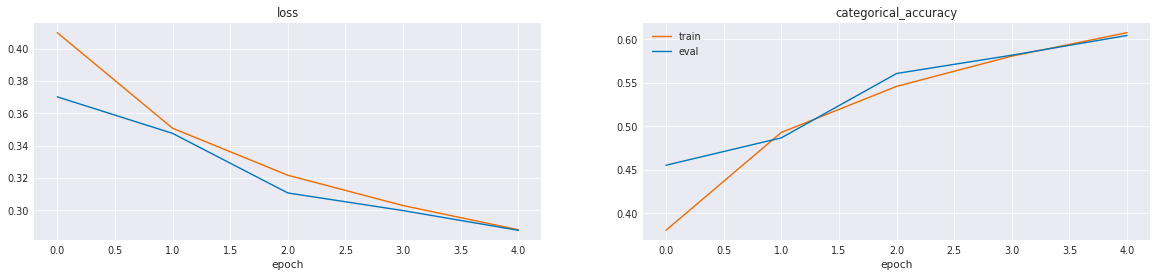

In [9]:
plotHistory(hist.history)
plt.savefig('cifar_history.png')